In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm
from keras import models, layers
import keras
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.optimizers import SGD
import tensorflow as tf

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')


import matplotlib.pyplot as plt
from matplotlib import style

import cv2
import random as rn
import os

In [ ]:
X = []
TEMP = []
projectDir = '/content/drive/MyDrive/MACS/6505/Project'
IMG_SIZE = 227
nImagesOrg = projectDir + "/assets/normal/"
pImagesOrg = projectDir + "/assets/potholes/"

In [ ]:
def process_data(label,DIR):
    for img in tqdm(os.listdir(DIR)):
        try:
            path = os.path.join(DIR,img)
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

            X.append(np.array(img))
            TEMP.append(str(label))
        except:
            pass

In [ ]:
process_data('NORMAL',nImagesOrg)

100%|██████████| 352/352 [01:48<00:00,  3.23it/s]


In [ ]:
process_data('POTHOLE',pImagesOrg)

100%|██████████| 329/329 [01:47<00:00,  3.05it/s]


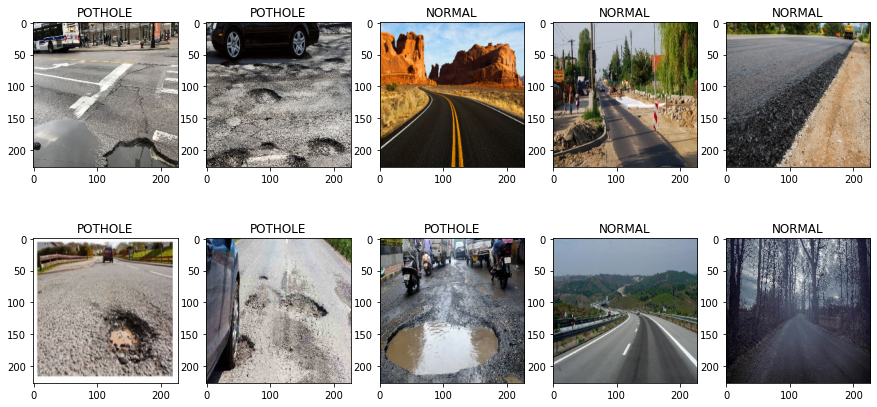

In [ ]:
fig,ax = plt.subplots(2,5)
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)
fig.set_size_inches(15,15)

for i in range(2):
    for j in range (5):
        l = rn.randint(0,len(TEMP))
        ax[i,j].imshow(X[l][:,:,::-1])
        ax[i,j].set_title(TEMP[l])
        ax[i,j].set_aspect('equal')

In [ ]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(TEMP)
Y = to_categorical(Y,2)
print(Y)
X = np.array(X)
X = X/255
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.25,random_state=0)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
X_train.shape

(510, 227, 227, 3)

In [ ]:
X_test.shape

(170, 227, 227, 3)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='accuracy', 
                                patience=3, 
                                verbose=1, 
                                factor=0.2, 
                                min_lr=1e-6)

In [ ]:
data_generator = ImageDataGenerator(
            rotation_range=10, 
            width_shift_range=0.1, 
            height_shift_range=0.1, 
            shear_range=0.1,
            zoom_range=0.2)
data_generator.fit(X_train) 

In [ ]:
class AlexNet(models.Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(layers.Conv2D(filters=96, kernel_size=(11, 11), strides=4, input_shape= input_shape, activation="relu", padding="same"))
        self.add(layers.MaxPool2D(pool_size=(3, 3),strides=(2, 2)))
        self.add(layers.Conv2D(filters=256, kernel_size=(5, 5), activation="relu", padding="same"))
        self.add(layers.MaxPool2D(pool_size=(3, 3),strides=(2, 2)))
        self.add(layers.Conv2D(filters=384, kernel_size=(3, 3), activation="relu", padding="same"))
        self.add(layers.Conv2D(filters=384, kernel_size=(3, 3), activation="relu", padding="same"))
        self.add(layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding="same"))
        self.add(layers.MaxPool2D(pool_size=(3, 3),strides=(2, 2)))
        self.add(layers.Flatten())
        self.add(layers.Dense(units=4096, activation='relu')) 
        self.add(layers.Dropout(0.5))
        self.add(layers.Dense(units=4096, activation='relu')) 
        self.add(layers.Dropout(0.5))
        self.add(layers.Dense(units=num_classes, activation='softmax'))  
        
        self.compile(loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(5)], optimizer=Adam(lr=5e-4))

In [ ]:
def plot_accuracy(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

In [ ]:
input_shape = (227, 227, 3)
num_classes = 2
epoch = 30
model = AlexNet(input_shape, num_classes)
model_history = model.fit_generator(data_generator.flow(X_train, y_train, batch_size=128), steps_per_epoch=len(X_train)/128, 
                    epochs=30, validation_data=(X_test, y_test), callbacks=[reduce_lr])
test_score = model.evaluate(X_test, y_test, batch_size=32)
print()
print('Test loss:', test_score[0]) 
print('Test accuracy:', test_score[1])

Epoch 1/30
3/3 [==============================] - 85s 21s/step - loss: 0.9026 - accuracy: 0.4930 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.6912 - val_accuracy: 0.5059 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/30
3/3 [==============================] - 83s 21s/step - loss: 0.6943 - accuracy: 0.4752 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.6888 - val_accuracy: 0.5412 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/30
3/3 [==============================] - 83s 21s/step - loss: 0.6927 - accuracy: 0.5251 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.6886 - val_accuracy: 0.4941 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/30
3/3 [==============================] - 83s 21s/step - loss: 0.6803 - accuracy: 0.5183 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.6447 - val_accuracy: 0.7941 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/30
3/3 [==============================] - 83s 21s/step - loss: 0.6208 - accuracy: 0.6992 - top_k_categorical_accuracy: 1.000

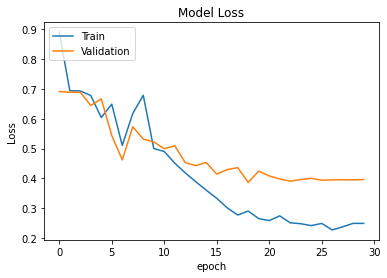

In [ ]:
plot_loss(model_history)
plt.show()

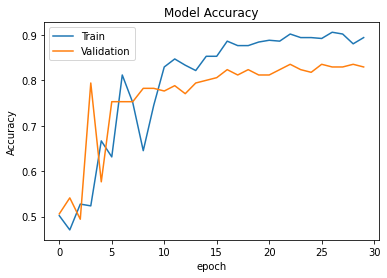

In [ ]:
plot_accuracy(model_history)
plt.show()

**Summary**

In [ ]:
model.summary()

Model: "alex_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 57, 57, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 384)       1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 256)       884

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(X_test)
matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print('Confusion Matrix:', matrix)
print('Classification Report:', classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

Confusion Matrix: [[66 18]
 [11 75]]
Classification Report:               precision    recall  f1-score   support

           0       0.86      0.79      0.82        84
           1       0.81      0.87      0.84        86

    accuracy                           0.83       170
   macro avg       0.83      0.83      0.83       170
weighted avg       0.83      0.83      0.83       170



**Visualization**

In [ ]:
import tensorflow as tf
import keras.backend as K

K.set_learning_phase(0)
logits = keras.models.Model(inputs=model.layers[0].input,outputs=model.layers[-2].output)
def visualize():
  print("Random Train Example")
  idx = rn.randint(0,len(X_train)-1)
  x_var = K.variable(X_train[idx:idx+1])
  with tf.GradientTape() as tape:
    tape.watch(x_var)
    y = tf.reduce_sum(logits(x_var)[:,label_encoder.transform(["POTHOLE"]).item()],axis=0)
  print(y)
  plt.axis("off")
  plt.imshow(x_var[0])
  plt.show()
  mask = tape.gradient(y,x_var)[0]
  plt.imshow(tf.reduce_sum(mask,axis=2))
  plt.show()

  print("Random Test Example")
  idx = rn.randint(0,len(X_test)-1)
  x_var = K.variable(X_test[idx:idx+1])
  with tf.GradientTape() as tape:
    tape.watch(x_var)
    y = tf.reduce_sum(logits(x_var)[:,label_encoder.transform(["POTHOLE"]).item()],axis=0)
  print(y)
  plt.axis("off")
  plt.imshow(x_var[0])
  plt.show()
  mask = tape.gradient(y,x_var)[0]
  plt.imshow(tf.reduce_sum(mask,axis=2))
  plt.show()

Random Train Example
tf.Tensor(0.055152647, shape=(), dtype=float32)


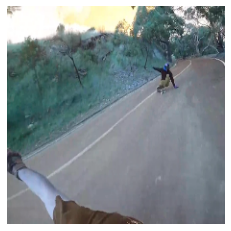

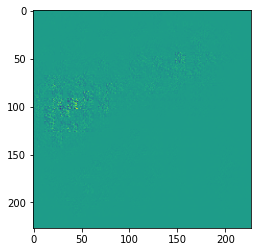

Random Test Example
tf.Tensor(0.0377062, shape=(), dtype=float32)


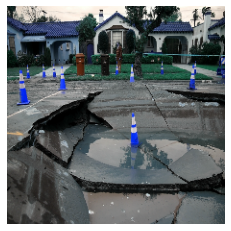

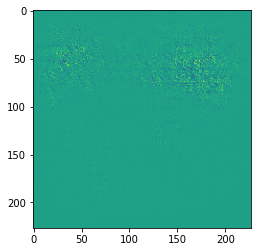

In [ ]:
visualize()